In [1]:
using GCVNode
using ForneyLab, DelimitedFiles, LinearAlgebra,Random,CSV, LaTeXStrings
Random.seed!(617) #for reproducibility
df = CSV.read("data/bitcoin_data.csv")
data = df.prices[100:500]
no_layers = 3
n_samples = length(data)
n_its = 10
;

┌ Info: Recompiling stale cache file /Users/ivan-bocharov/.julia/compiled/v1.2/GCVNode/aqv87.ji for GCVNode [477277bc-387f-11ea-3602-e589d8402389]
└ @ Base loading.jl:1240


In [2]:
g = FactorGraph()
@RV γ1 ~ Gamma(placeholder(:a1),placeholder(:b1))
@RV γ2 ~ Gamma(placeholder(:a2),placeholder(:b2))
@RV κ1_t ~ GaussianMeanPrecision(placeholder(:mκ1_t),placeholder(:wκ1_t))
@RV κ2_t ~ GaussianMeanPrecision(placeholder(:mκ2_t),placeholder(:wκ2_t))
@RV ω1_t ~ GaussianMeanPrecision(placeholder(:mω1_t),placeholder(:wω1_t))
@RV ω2_t ~ GaussianMeanPrecision(placeholder(:mω2_t),placeholder(:wω2_t))
@RV z_t_min ~ GaussianMeanPrecision(placeholder(:mz_t_min),placeholder(:wz_t_min))
@RV z_t ~ GaussianMeanPrecision(z_t_min,γ2)
@RV s_t_min ~ GaussianMeanPrecision(placeholder(:ms_t_min),placeholder(:ws_t_min))
@RV s_t ~ GaussianControlledVariance(s_t_min,z_t,κ2_t,ω2_t)
@RV x_t_min ~ GaussianMeanPrecision(placeholder(:mx_t_min),placeholder(:wx_t_min))
@RV x_t ~ GaussianControlledVariance(x_t_min,s_t,κ1_t,ω1_t)
@RV y_t ~ GaussianMeanPrecision(x_t,γ1)
placeholder(y_t, :y_t )

q = RecognitionFactorization([z_t,z_t_min],[x_t,x_t_min],[s_t,s_t_min],κ1_t,ω1_t,κ2_t,ω2_t,γ1,γ2,
ids=[:Z,:X,:S,:K1,:O1,:K2,:O2,:Γ1,:Γ2])

algo = variationalAlgorithm(q)
algo_f = freeEnergyAlgorithm(q)
eval(Meta.parse(algo))
eval(Meta.parse(algo_f))
marginals = Dict()
data_dict = Dict()

function initZ(mz,wz)
    messages = Array{Message}(undef, 4)
    messages[1] = Message(Univariate,GaussianMeanPrecision,m=mz,w=wz)
    return messages
end

function initS(ms,ws)
    messages = Array{Message}(undef, 4)
    messages[1]= Message(Univariate,GaussianMeanPrecision,m=ms,w=ws)
    return messages
end
;

In [3]:
mx = Array{Float64}(undef,n_samples)
vx = Array{Float64}(undef,n_samples)
ms = Array{Float64}(undef,n_samples)
vs = Array{Float64}(undef,n_samples)
mz = Array{Float64}(undef,n_samples)
vz = Array{Float64}(undef,n_samples)
F_sq = Array{Float64}(undef,n_samples-1,n_its)
mω1 = Array{Float64}(undef,n_samples)
vω1 = Array{Float64}(undef,n_samples)
mω2 = Array{Float64}(undef,n_samples)
vω2 = Array{Float64}(undef,n_samples)
mκ1 = Array{Float64}(undef,n_samples)
vκ1 = Array{Float64}(undef,n_samples)
mκ2 = Array{Float64}(undef,n_samples)
vκ2 = Array{Float64}(undef,n_samples)

marginals[:x_t_x_t_min] = ProbabilityDistribution(Multivariate,GaussianMeanVariance,m=zeros(2),v=1*diageye(2))
marginals[:x_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:z_t_z_t_min] = ProbabilityDistribution(Multivariate,GaussianMeanVariance,m=[0.0 ; 0.0],v=[1.0 0.; 0. 1.0])
marginals[:z_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:s_t_s_t_min] = ProbabilityDistribution(Multivariate,GaussianMeanVariance,m=[0.0 ; 0.0],v=[1.0 0.; 0. 1.0])
marginals[:s_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:ω1_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:ω2_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:κ2_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:κ1_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:γ1] = vague(Gamma)
marginals[:γ2] = vague(Gamma)
messages_z = initZ(1.0,0.1)
messages_s = initS(1.0,0.1);

In [4]:
mx[1] = data[1]
vx[1] = var(data[1:20])
ms[1] = 1.0
vs[1] = 1.0
mz[1] = 1.0
vz[1] = 0.1
params = [1.0; 0.0; 1.0; 0.0]
params_var = [0.01; 10.0; 0.01 ; 10.0]
a1 = 0.001
b1 = 0.001
a2 = 0.01
b2 = 0.01
;

In [5]:
for t=2:n_samples
    global a1,b1,a2,b2
    data_dict[:y_t] = data[t]
    data_dict[:mx_t_min] = mx[t-1]
    data_dict[:wx_t_min] = 1/(vx[t-1]+0.001)
    data_dict[:mz_t_min] = mz[t-1]
    data_dict[:wz_t_min] = 1/vz[t-1]
    data_dict[:ms_t_min] = ms[t-1]
    data_dict[:ws_t_min] = 1/(vs[t-1])
    data_dict[:mκ1_t] = params[1]
    data_dict[:mκ2_t] = params[3]
    data_dict[:mω1_t] = params[2]
    data_dict[:mω2_t] = params[4]
    data_dict[:wκ1_t] = 1/(params_var[1])
    data_dict[:wκ2_t] = 1/(params_var[3])
    data_dict[:wω1_t] = 1/(params_var[2])
    data_dict[:wω2_t] = 1/(params_var[4])
    data_dict[:a1] = a1
    data_dict[:a2] = a2
    data_dict[:b1] = b1
    data_dict[:b2] = b2

    for i=1:n_its
        stepX!(data_dict,marginals)
        stepS!(data_dict,marginals,messages_s)
        stepZ!(data_dict,marginals,messages_z)
        stepO1!(data_dict,marginals)
        stepO2!(data_dict,marginals)
        stepΓ2!(data_dict,marginals)
        stepΓ1!(data_dict,marginals)
        stepK1!(data_dict,marginals)
        stepK2!(data_dict,marginals)
        F_sq[t-1,i] =freeEnergy(data_dict,marginals)

    end


    mx[t], vx[t] = ForneyLab.unsafeMeanCov(marginals[:x_t])
    mz[t], vz[t] = ForneyLab.unsafeMeanCov(marginals[:z_t])
    ms[t], vs[t] = ForneyLab.unsafeMeanCov(marginals[:s_t])
    params[1] ,params_var[1]  = ForneyLab.unsafeMeanCov(marginals[:κ1_t])
    params[2] ,params_var[2] = ForneyLab.unsafeMeanCov(marginals[:ω1_t])
    params[3] ,params_var[3]  = ForneyLab.unsafeMeanCov(marginals[:κ2_t])
    params[4] ,params_var[4] = ForneyLab.unsafeMeanCov(marginals[:ω2_t])
    (a1, b1) = (marginals[:γ1].params[:a],marginals[:γ1].params[:b])
    (a2, b2) = (marginals[:γ2].params[:a],marginals[:γ2].params[:b])
    mκ1[t], vκ1[t] = ForneyLab.unsafeMeanCov(marginals[:κ1_t])
    mω1[t], vω1[t] = ForneyLab.unsafeMeanCov(marginals[:ω1_t])
    mκ2[t], vκ2[t]  = ForneyLab.unsafeMeanCov(marginals[:κ2_t])
    mω2[t], vω2[t] = ForneyLab.unsafeMeanCov(marginals[:ω2_t])

end

In [6]:
mκ1[1], vκ1[1] = 1.0, 0.01
mω1[1], vω1[1] = 0.0, 10.0
mκ2[1], vκ2[1]  = 1.0, 0.01
mω2[1], vω2[1] = 0.0, 10.0
prediction = Array{Float64}(undef,n_samples)
prediction_var = Array{Float64}(undef,n_samples)
for t=1:n_samples
    prediction_var[t] = sqrt(exp(mκ1[t]*ms[t]+mω1[t]))
    # prediction_var[t] = vx[t]
    prediction[t] = mx[t] + prediction_var[t]*randn()
end

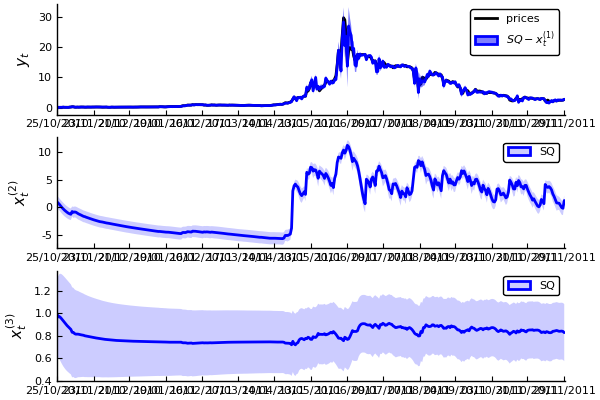

In [7]:
using Plots
font1 = Plots.font(12)
pyplot(guidefont=font1, xtickfont=font1, ytickfont=font1, legendfont=font1)
Plots.reset_defaults()
Plots.scalefontsizes()
t = 1:n_samples
pyplot(legend=true, xlims=(t[1], t[end]),linewidth=2.0)
plot_y = plot(grid=false)
plot!(df.date[100:500],data,label="prices",color="black", ylabel=L"y_t",linewidth=2.0)
plot!(df.date[100:500],prediction[t],ribbon=prediction_var[t], color="blue", alpha=1.0,label=L"SQ-x^{(1)}_t")
plot_x = plot(grid=false)
plot!(df.date[100:500], ms[t], ribbon=sqrt.(vs[t]),color="blue",alpha=1,fillalpha=0.2,label="SQ",ylabel=L"x^{(2)}_t")
plot_z = plot(grid=false)
plot!(df.date[100:500], mz[t], ribbon=sqrt.(vz[t]),color="blue",alpha=1,fillalpha=0.2,label="SQ",ylabel=L"x^{(3)}_t")
plot(plot_y,plot_x,plot_z,layout=(3,1),sharex=true,svg=true)

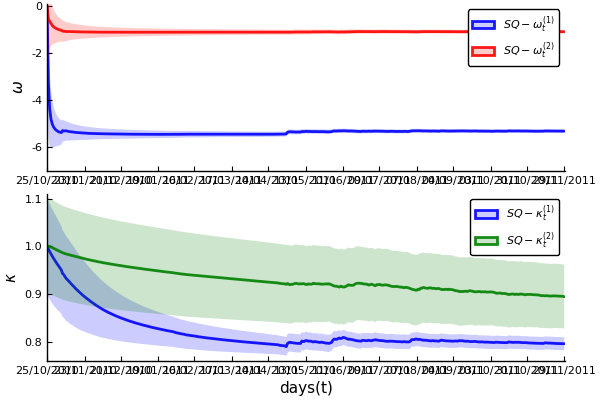

In [8]:
plot_ω1 = plot()
plot!(df.date[100:500], mω1[t],ribbon=sqrt.(vω1[t]),color="blue",alpha=0.9,fillalpha=0.2,label=L"SQ-\omega^{(1)}_t",ylabel=L"\omega")
plot!(df.date[100:500], mω2[t], ribbon=sqrt.(vω2[t]),color="red",alpha=0.9,label=L"SQ-\omega^{(2)}_t",ylims=(-7.,0.1),ylabel=L"\omega",fillalpha=0.2)
plot_κ1 = plot()
plot!(df.date[100:500], mκ1[t], ribbon=sqrt.(vκ1[t]),color="blue",alpha=0.9,ylabel=L"\kappa",fillalpha=0.2,label=L"SQ-\kappa^{(1)}_t",)
plot!(df.date[100:500], mκ2[t], ribbon=sqrt.(vκ2[t]),color="green",alpha=0.9,xlabel="days(t)",ylabel=L"\kappa",fillalpha=0.2,label=L"SQ-\kappa^{(2)}_t")
plot(plot_ω1,plot_κ1,layout=(2,1),sharex=true,svg=true,grid=false,legend=:topright)

In [9]:
fg = FactorGraph()
@RV s_t
@RV x_t
@RV γ1 ~ Gamma(placeholder(:a1),placeholder(:b1))
@RV γ2 ~ Gamma(placeholder(:a2),placeholder(:b2))
@RV κ1_t ~ GaussianMeanPrecision(placeholder(:mκ1_t),placeholder(:wκ1_t))
@RV κ2_t ~ GaussianMeanPrecision(placeholder(:mκ2_t),placeholder(:wκ2_t))
@RV ω1_t ~ GaussianMeanPrecision(placeholder(:mω1_t),placeholder(:wω1_t))
@RV ω2_t ~ GaussianMeanPrecision(placeholder(:mω2_t),placeholder(:wω2_t))
@RV z_t_min ~ GaussianMeanPrecision(placeholder(:mz_t_min),placeholder(:wz_t_min))
@RV z_t ~ GaussianMeanPrecision(z_t_min,γ2)
@RV s_t_min ~ GaussianMeanPrecision(placeholder(:ms_t_min),placeholder(:ws_t_min))
HGF(s_t,s_t_min,z_t,κ2_t,ω2_t)
@RV x_t_min ~ GaussianMeanPrecision(placeholder(:mx_t_min),placeholder(:wx_t_min))
HGF(x_t,x_t_min,s_t,κ1_t,ω1_t)
@RV y_t ~ GaussianMeanPrecision(x_t,γ1)
placeholder(y_t, :y_t )


q = RecognitionFactorization(z_t,z_t_min,x_t,x_t_min,s_t,s_t_min,κ1_t,ω1_t,κ2_t,ω2_t,γ1,γ2,
ids=[:Z,:Z_min,:X,:X_min,:S,:S_min,:K1,:O1,:K2,:O2,:Γ1,:Γ2])

algo = variationalAlgorithm(q)
algo_f = freeEnergyAlgorithm(q)
eval(Meta.parse(algo))
eval(Meta.parse(algo_f))
marginals = Dict()
data_dict = Dict()
;

In [10]:
mx = Array{Float64}(undef,n_samples)
vx = Array{Float64}(undef,n_samples)
ms = Array{Float64}(undef,n_samples)
vs = Array{Float64}(undef,n_samples)
mz = Array{Float64}(undef,n_samples)
vz = Array{Float64}(undef,n_samples)
F_mf = Array{Float64}(undef,n_samples-1,n_its)
mω1 = Array{Float64}(undef,n_samples)
vω1 = Array{Float64}(undef,n_samples)
mω2 = Array{Float64}(undef,n_samples)
vω2 = Array{Float64}(undef,n_samples)
mκ1 = Array{Float64}(undef,n_samples)
vκ1 = Array{Float64}(undef,n_samples)
mκ2 = Array{Float64}(undef,n_samples)
vκ2 = Array{Float64}(undef,n_samples)
marginals[:x_t_min] = ProbabilityDistribution(Multivariate,GaussianMeanVariance,m=0.0,v=1.0)
marginals[:x_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:z_t] = ProbabilityDistribution(Multivariate,GaussianMeanVariance,m=0.0,v=1.0)
marginals[:z_t_min] = ProbabilityDistribution(Multivariate,GaussianMeanVariance,m=0.0,v=1.0)
marginals[:z_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:s_t_min] = ProbabilityDistribution(Multivariate,GaussianMeanVariance,m=0.0,v=1.0)
marginals[:s_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:ω1_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:ω2_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:κ2_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:κ1_t] = ProbabilityDistribution(GaussianMeanVariance,m=0.0,v=1.0)
marginals[:γ1] = vague(Gamma)
marginals[:γ2] = vague(Gamma);

In [11]:
mx[1] = data[1]
vx[1] = var(data[1:20])
ms[1] = 1.0
vs[1] = 1.0
mz[1] = 1.0
vz[1] = 0.1
params = [1.0; 0.0; 1.0; 0.0]
params_var = [0.01; 10.0; 0.01 ; 10.0]
a1 = 0.001
b1 = 0.001
a2 = 0.01
b2 = 0.01

0.01

In [12]:
for t=2:n_samples
    global a1,b1,a2,b2
    data_dict[:y_t] = data[t]
    data_dict[:mx_t_min] = mx[t-1]
    data_dict[:wx_t_min] = 1/(vx[t-1]+0.001)
    data_dict[:mz_t_min] = mz[t-1]
    data_dict[:wz_t_min] = 1/vz[t-1]
    data_dict[:ms_t_min] = ms[t-1]
    data_dict[:ws_t_min] = 1/(vs[t-1])
    data_dict[:mκ1_t] = params[1]
    data_dict[:mκ2_t] = params[3]
    data_dict[:mω1_t] = params[2]
    data_dict[:mω2_t] = params[4]
    data_dict[:wκ1_t] = 1/(params_var[1])
    data_dict[:wκ2_t] = 1/(params_var[3])
    data_dict[:wω1_t] = 1/(params_var[2])
    data_dict[:wω2_t] = 1/(params_var[4])
    data_dict[:a1] = a1
    data_dict[:a2] = a2
    data_dict[:b1] = b1
    data_dict[:b2] = b2

    for i=1:n_its
        stepX_min!(data_dict,marginals)
        stepZ_min!(data_dict,marginals)
        stepS_min!(data_dict,marginals)
        stepX!(data_dict,marginals)
        stepS!(data_dict,marginals)
        stepZ!(data_dict,marginals)
        stepO1!(data_dict,marginals)
        stepO2!(data_dict,marginals)
        stepΓ2!(data_dict,marginals)
        stepΓ1!(data_dict,marginals)
        stepK1!(data_dict,marginals)
        stepK2!(data_dict,marginals)
        F_mf[t-1,i] =freeEnergy(data_dict,marginals)

    end


    mx[t], vx[t] = ForneyLab.unsafeMeanCov(marginals[:x_t])
    mz[t], vz[t] = ForneyLab.unsafeMeanCov(marginals[:z_t])
    ms[t], vs[t] = ForneyLab.unsafeMeanCov(marginals[:s_t])
    params[1] ,params_var[1]  = ForneyLab.unsafeMeanCov(marginals[:κ1_t])
    params[2] ,params_var[2] = ForneyLab.unsafeMeanCov(marginals[:ω1_t])
    params[3] ,params_var[3]  = ForneyLab.unsafeMeanCov(marginals[:κ2_t])
    params[4] ,params_var[4] = ForneyLab.unsafeMeanCov(marginals[:ω2_t])
    (a1, b1) = (marginals[:γ1].params[:a],marginals[:γ1].params[:b])
    (a2, b2) = (marginals[:γ2].params[:a],marginals[:γ2].params[:b])
    mκ1[t], vκ1[t] = ForneyLab.unsafeMeanCov(marginals[:κ1_t])
    mω1[t], vω1[t] = ForneyLab.unsafeMeanCov(marginals[:ω1_t])
    mκ2[t], vκ2[t]  = ForneyLab.unsafeMeanCov(marginals[:κ2_t])
    mω2[t], vω2[t] = ForneyLab.unsafeMeanCov(marginals[:ω2_t])

end
;

In [13]:
mκ1[1], vκ1[1] = 1.0, 0.01
mω1[1], vω1[1] = 0.0, 10.0
mκ2[1], vκ2[1]  = 1.0, 0.01
mω2[1], vω2[1] = 0.0, 10.0
prediction = Array{Float64}(undef,n_samples)
prediction_var = Array{Float64}(undef,n_samples)
for t=1:n_samples
    prediction_var[t] = sqrt(exp(mκ1[t]*ms[t]+mω1[t]))
    prediction[t] = mx[t] + prediction_var[t]*randn()
end

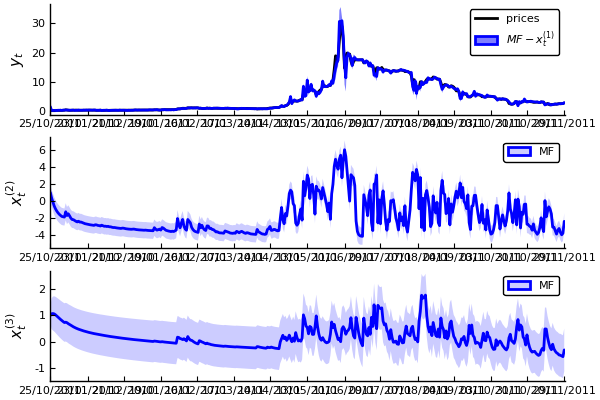

In [14]:
t = 1:n_samples
pyplot(legend=true, xlims=(t[1], t[end]),linewidth=2.0)
plot_y = plot(grid=false)
plot!(df.date[100:500],data,label="prices",color="black", ylabel=L"y_t",linewidth=2.0)
plot!(df.date[100:500],prediction[t],ribbon=prediction_var[t], color="blue", alpha=1.0,label=L"MF-x^{(1)}_t")
plot_x = plot(grid=false)
plot!(df.date[100:500], ms[t], ribbon=sqrt.(vs[t]),color="blue",alpha=1,fillalpha=0.2,label="MF",ylabel=L"x^{(2)}_t")
plot_z = plot(grid=false)
plot!(df.date[100:500], mz[t], ribbon=sqrt.(vz[t]),color="blue",alpha=1,fillalpha=0.2,label="MF",ylabel=L"x^{(3)}_t")
plot(plot_y,plot_x,plot_z,layout=(3,1),sharex=true,svg=true)

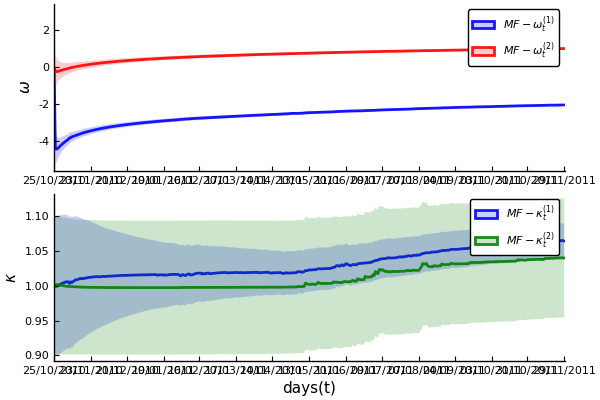

In [15]:
plot_ω1 = plot()
plot!(df.date[100:500], mω1[t],ribbon=sqrt.(vω1[t]),color="blue",alpha=0.9,fillalpha=0.2,label=L"MF-\omega^{(1)}_t",ylabel=L"\omega")
plot!(df.date[100:500], mω2[t], ribbon=sqrt.(vω2[t]),color="red",alpha=0.9,label=L"MF-\omega^{(2)}_t",ylabel=L"\omega",fillalpha=0.2)
plot_κ1 = plot()
plot!(df.date[100:500], mκ1[t], ribbon=sqrt.(vκ1[t]),color="blue",alpha=0.9,ylabel=L"\kappa",fillalpha=0.2,label=L"MF-\kappa^{(1)}_t",)
plot!(df.date[100:500], mκ2[t], ribbon=sqrt.(vκ2[t]),color="green",alpha=0.9,xlabel="days(t)",ylabel=L"\kappa",fillalpha=0.2,label=L"MF-\kappa^{(2)}_t")
plot(plot_ω1,plot_κ1,layout=(2,1),sharex=true,svg=true,grid=false,legend=:topright)

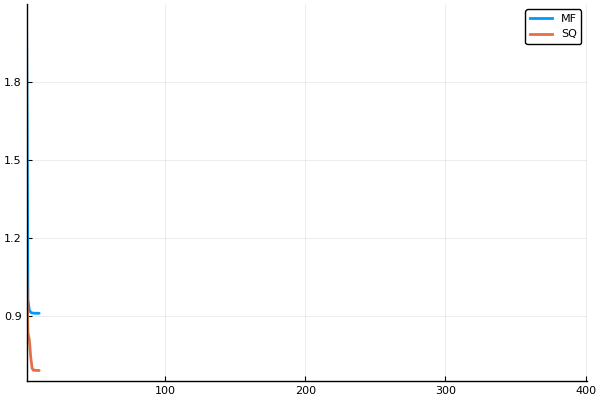

In [16]:
i = 1:n_its
plot(svg=true)
pyplot(legend=true, xlims=(i[1], i[end]))
plot!(i,sum(F_mf,dims=1)'/n_samples,label="MF")
plot!(i,sum(F_sq,dims=1)'/n_samples,label="SQ")